First we will import.

In [1]:
import requests
import pandas as pd
import numpy as np
import csv
from sqlalchemy import create_engine
from pathlib import Path
import os
from psycopg2 import sql
from psycopg2.extras import execute_values

Lets grab and explore the DND 5E API

In [2]:
api_url = "https://www.dnd5eapi.co/api"
req = requests.get(api_url)
base_dict = req.json()
base_url = "https://www.dnd5eapi.co"

Find quick view of all of the dictionaries

In [5]:
#loop through our base dictionary and print the api pull for each area. 
#this should make it easier for me to identify good approaches for each section.
for k in base_dict.keys():
    mystr= 'https://www.dnd5eapi.co'
    mystr+=base_dict[k]
    

In [6]:
#gather all of the top data on monsters
mystr= 'https://www.dnd5eapi.co/api/monsters/'
response= requests.get(mystr).json()['results']



In [7]:
#grab all monster top level data
monsters=[]
for i in response:
    newstr=base_url+(i['url'])
    mdata= requests.get(newstr).json()
    monsters.append(mdata)   


create Monster Data frame to easily walk through info

In [10]:
current_directory = os.getcwd() 
print(current_directory)
#current_directory = os.path.dirname(os.path.abspath(__file__))
x = os.path.join(current_directory, 'src', 'data')

print(x)


c:\Users\Logan\Documents\GitHub\5e_Companion
c:\Users\Logan\Documents\GitHub\5e_Companion\src\data


In [8]:
df_mon = pd.DataFrame.from_dict(monsters)
print(r"C:\Users\Logan\Documents\GitHub\5e_Companion\src\data\raw_monster.csv")
df_mon.to_csv(r"C:\Users\Logan\Documents\GitHub\5e_Companion\src\data\raw_monster.csv")

C:\Users\Logan\Documents\GitHub\5e_Companion\src\data\raw_monster.csv


Monster Table Creation!

In [9]:
#first we fix it to natural AC, equipped AC wouldnt make sense to be the default for AC 
df_mon['natural_ac']= [ac[0]['value'] for ac in df_mon.armor_class]
#


In [13]:
maxs=0
ss=''
for s in df_mon.speed:
    if len(s)>maxs:
        maxs=len(s)
        ss=s
print(maxs)
print(ss)

4
{'walk': '40 ft.', 'burrow': '30 ft.', 'fly': '80 ft.', 'swim': '40 ft.'}


In [14]:
df_mon['speed_walk']=''
df_mon['speed_swim']=''
df_mon['speed_fly']=''
df_mon['speed_burrow']=''


split the movement speeds. they max out at 4 types and are worth being in their own columns due to the nature of how core they are to the mechanics of the monster.

In [15]:
walk =[]
swim=[]
fly=[]
burr=[]
for s in df_mon.speed:
    try:
        walk.append(s['walk'].split(" ")[0])
    except:
        walk.append(np.nan)
    try:
        swim.append(s['swim'].split(" ")[0])
    except:
        swim.append(np.nan)
    try:
        fly.append(s['fly'].split(" ")[0])
    except:
        fly.append(np.nan)
    try:
        burr.append(s['burrow'].split(" ")[0])
    except:
        burr.append(np.nan)


df_mon['speed_walk']=walk
df_mon['speed_swim']=swim
df_mon['speed_fly']=fly
df_mon['speed_burrow']=burr



Now we can begin to order the monster_sql DF to make a proper master table for monster.

In [16]:
df_mon.keys()

Index(['index', 'name', 'size', 'type', 'alignment', 'armor_class',
       'hit_points', 'hit_dice', 'hit_points_roll', 'speed', 'strength',
       'dexterity', 'constitution', 'intelligence', 'wisdom', 'charisma',
       'proficiencies', 'damage_vulnerabilities', 'damage_resistances',
       'damage_immunities', 'condition_immunities', 'senses', 'languages',
       'challenge_rating', 'xp', 'special_abilities', 'actions',
       'legendary_actions', 'image', 'url', 'desc', 'subtype', 'reactions',
       'forms', 'natural_ac', 'speed_walk', 'speed_swim', 'speed_fly',
       'speed_burrow'],
      dtype='object')

In [17]:
mon_table_df=df_mon[['index','name','size','type','alignment','natural_ac','speed_walk','speed_swim','speed_fly','speed_burrow','strength','dexterity','constitution','intelligence','wisdom','charisma','challenge_rating','xp','image','desc']]

mon_table_df.rename(columns={'index': 'monster_id'}, inplace=True)
mon_table_df.rename(columns={'desc': 'descrip'}, inplace=True)

C:\Users\Logan\AppData\Local\Temp\ipykernel_3952\561032444.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mon_table_df.rename(columns={'index': 'monster_id'}, inplace=True)
C:\Users\Logan\AppData\Local\Temp\ipykernel_3952\561032444.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mon_table_df.rename(columns={'desc': 'descrip'}, inplace=True)


Perfect, we now have our monster main table DF.

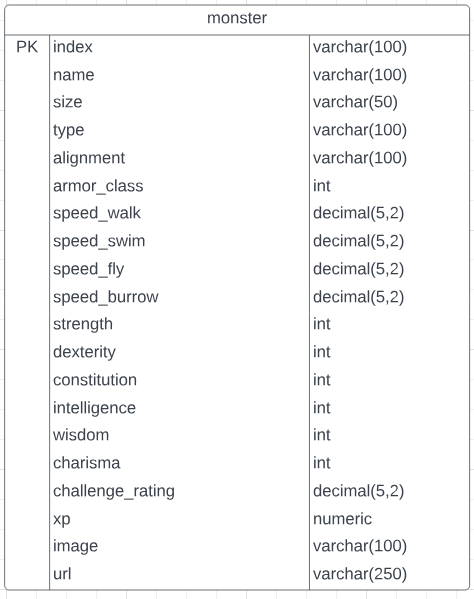


In [18]:
#find the max length of the description field for the sql environment


In [10]:
df_mon_mit = df_mon[['index','damage_vulnerabilities','damage_resistances','damage_immunities','condition_immunities']]
df_mon_facet=df_mon[['index','proficiencies','senses','languages','forms']]
df_mon_action=df_mon[['index','actions','special_abilities','legendary_actions']]

df_mon_mit.head()

In [20]:
csv_data = []
with open(r"C:\Users\Logan\Documents\GitHub\5e_Companion\src\data\monsters.csv", 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)  # Skip the header
    for row in csv_reader:
        csv_data.append(row)

In [21]:
investigate=[]
for imm in df_mon_mit['damage_immunities']:
    if len(imm)>0:
        investigate.append(imm)
print(investigate)

[['acid'], ['lightning'], ['fire'], ['lightning'], ['acid'], ['fire'], ['poison'], ['fire'], ['cold'], ['cold'], ['poison'], ['acid'], ['lightning'], ['fire'], ['lightning'], ['acid'], ['fire'], ['poison'], ['fire'], ['cold'], ['cold'], ['psychic', 'bludgeoning, piercing, and slashing from nonmagical weapons'], ['poison', 'psychic'], ['fire', 'poison'], ['fire', 'poison'], ['fire', 'poison'], ['fire', 'poison'], ['lightning'], ['acid'], ['acid', 'cold', 'lightning', 'slashing'], ['lightning'], ['fire', 'poison'], ['fire'], ['lightning'], ['fire', 'poison'], ['poison'], ['acid', 'poison', 'psychic', "bludgeoning, piercing, and slashing from nonmagical weapons that aren't adamantine"], ['acid'], ['psychic', 'bludgeoning, piercing, and slashing from nonmagical weapons'], ['lightning', 'thunder'], ['poison'], ['poison'], ['poison'], ['fire'], ['fire', 'poison'], ['fire', 'poison'], ['fire'], ['lightning', 'poison', "bludgeoning, piercing, and slashing from nonmagical weapons that aren't ad

In [11]:
df_mon_mit.head()

,index,damage_vulnerabilities,damage_resistances,damage_immunities,condition_immunities
0,aboleth,[],[],[],[]
1,acolyte,[],[],[],[]
2,adult-black-dragon,[],[],[acid],[]
3,adult-blue-dragon,[],[],[lightning],[]
4,adult-brass-dragon,[],[],[fire],[]


In [17]:
#now lets loop through and create a massive list for this.
resistances=[]
h=['monster_id','type','value']

       

for imm in df_mon_mit.values:
    for j in range(1,len(df_mon_mit.keys())):
        if len(imm[j])>0:
            if type(imm[j][0])==dict:
                for i in imm[j]:
                    resistances.append([imm[0],df_mon_mit.columns[j],i['name']])
            else:
                for i in imm[j]:
                    resistances.append([imm[0],df_mon_mit.columns[j],i])









print(len(resistances))
print(resistances)

df_resist = pd.DataFrame(resistances,columns=h)
df_resist.head()
df_resist.to_csv(r'C:\Users\Logan\Documents\GitHub\5e_Companion\src\data\monster_resists.csv',index=False)

713
[['adult-black-dragon', 'damage_immunities', 'acid'], ['adult-blue-dragon', 'damage_immunities', 'lightning'], ['adult-brass-dragon', 'damage_immunities', 'fire'], ['adult-bronze-dragon', 'damage_immunities', 'lightning'], ['adult-copper-dragon', 'damage_immunities', 'acid'], ['adult-gold-dragon', 'damage_immunities', 'fire'], ['adult-green-dragon', 'damage_immunities', 'poison'], ['adult-green-dragon', 'condition_immunities', 'Poisoned'], ['adult-red-dragon', 'damage_immunities', 'fire'], ['adult-silver-dragon', 'damage_immunities', 'cold'], ['adult-white-dragon', 'damage_immunities', 'cold'], ['air-elemental', 'damage_resistances', 'lightning'], ['air-elemental', 'damage_resistances', 'thunder'], ['air-elemental', 'damage_resistances', 'bludgeoning, piercing, and slashing from nonmagical weapons'], ['air-elemental', 'damage_immunities', 'poison'], ['air-elemental', 'condition_immunities', 'Exhaustion'], ['air-elemental', 'condition_immunities', 'Grappled'], ['air-elemental', 'con

In [13]:
df_resist[(df_resist['monster_id']=='wraith')]

,monster_id,type,value
683,wraith,damage_resistances,acid
684,wraith,damage_resistances,cold
685,wraith,damage_resistances,fire
686,wraith,damage_resistances,lightning
687,wraith,damage_resistances,thunder
688,wraith,damage_resistances,"bludgeoning, piercing, and slashing from nonma..."
689,wraith,damage_immunities,necrotic
690,wraith,damage_immunities,poison
691,wraith,condition_immunities,Charmed
692,wraith,condition_immunities,Exhaustion


Build the monster characteristics page


In [25]:
features=[]
h=['monster_id','characteristic','attribute_name','value']
#due to the varying degrees of how the data is stored there is only messy way to clean it up

#-----------------------proficiencies---------------------------
for imm in df_mon_facet[['index','proficiencies']].values:
    #all dictionaries are in a list
    if type(imm[1])== list:
        #iterate through listed dictionary
        for i in imm[1]:
            features.append([imm[0],'proficiency',i['proficiency']['name'],i['value']])

#-----------------------languagess-----------------------------
for imm in df_mon_facet[['index','languages']].values:
    if type(imm[1])== str:
        #these for some reason are comma split as a string and not a list
        for i in imm[1].split(','):
            #very weird one off case of telepgathy having a value but not listed as a value
            #so we extract it from the string
            val=''.join(j for j in i if j.isnumeric()==True)
            #sanitize the variable
            if len(val)==0:
                val=np.nan
            else:
                val=int(val)
            features.append([imm[0],'language',i,val])

#--------------------------grab forms -------------------
for imm in df_mon_facet[['index','forms']].values:

    if type(imm[1])!= float:
        for i in imm[1]:
            features.append([imm[0],'forms',i['name'],np.nan])
           
#-----------------------grab sense data-------------------
for imm in df_mon_facet[['index','senses']].values:
    if len(imm)>0:
        for k,v in imm[1].items():
            if type(v)==str:
                val = v.split(" ")
                val= val[0]
            else:
                val=v    
            features.append([imm[0],'senses',k,val])


df_characteristics= pd.DataFrame(features,columns=h)

df_characteristics.head()
df_characteristics.to_csv(r'C:\Users\Logan\Documents\GitHub\5e_Companion\src\data\monster_characteristics.csv')

In [26]:
df_mon_action.head()




,index,actions,special_abilities,legendary_actions
0,aboleth,"[{'name': 'Multiattack', 'multiattack_type': '...","[{'name': 'Amphibious', 'desc': 'The aboleth c...","[{'name': 'Detect', 'desc': 'The aboleth makes..."
1,acolyte,"[{'name': 'Club', 'desc': 'Melee Weapon Attack...","[{'name': 'Spellcasting', 'desc': 'The acolyte...",[]
2,adult-black-dragon,"[{'name': 'Multiattack', 'multiattack_type': '...","[{'name': 'Amphibious', 'desc': 'The dragon ca...","[{'name': 'Detect', 'desc': 'The dragon makes ..."
3,adult-blue-dragon,"[{'name': 'Multiattack', 'multiattack_type': '...","[{'name': 'Legendary Resistance', 'desc': 'If ...","[{'name': 'Detect', 'desc': 'The dragon makes ..."
4,adult-brass-dragon,"[{'name': 'Multiattack', 'multiattack_type': '...","[{'name': 'Legendary Resistance', 'desc': 'If ...","[{'name': 'Detect', 'desc': 'The dragon makes ..."


TIME TO BUILD THE DREADED Action Table
this is a very detailed area that required a lot of exceptions to deal with formatting of the dictionary

index,name, attack_bonus, damage_type, damage_dice dc ,usage, desc

#blacklist multi-attack needless data duplication, loop back through and add multi attack variable count?
#breath logic is unique for dragons and should be sleep breath or flame breath examplew

In [27]:
actions=[]
h=['monster_id','action_type','action_name','damage_type','attack_bonus','damage_dice','dc_type','dc_value','desc']
#due to the varying degrees of how the data is stored there is only messy way to clean it up
print(h)


#------------------------------------------------actions table--------------------------------------------------
for imm in df_mon_action[['index','legendary_actions']].values:
    #all dictionaries are in a list
    if type(imm[1])==list:
        #iterate through listed dictionary
        for i in imm[1]:
            if (i['name']!='Multiattack' and i['name']!='Breath Weapons') :
                # try block to iterate through the dictionary and parse the data
                name = i['name']
                #--------------------------------------------------------------------
                try:
                    AB = i['attack_bonus']
                except:
                    AB = np.nan
                #--------------------------------------------------------------------
                try:
                    damagetype = " & ".join(j['damage_type']['name'] for j in i['damage'])
                except:
                    damagetype = np.nan
                #---------------------------------------------------------------------------
                try:
                    damagetype = " & ".join(j['damage_type']['name'] for j in i['damage'])
                except:
                    damagetype = np.nan
                #---------------------------------------------------------------------------
                try:
                    damagedice = " + ".join(j['damage_dice'] for j in i['damage'])
                except:
                    damagedice = np.nan
                #-------------------------------------------------------------------
                try:
                    dc_type = i['dc']['dc_type']['name']
                except:
                    dc_type = np.nan
                #-----------------------------------------------------------------------           
                try:
                    dc_value = i['dc']['dc_value']
                except:
                    dc_value = np.nan
                #--------------------------------------------------------------------
                try:
                    desc= i['desc']
                except:
                    desc= np.nan

            #base action list apply
    
                actions.append([imm[0],'legendary actions',i['name'],damagetype,AB,damagedice,dc_type,dc_value,desc])

#------------------------------------------------actions table--------------------------------------------------
for imm in df_mon_action[['index','special_abilities']].values:
    #all dictionaries are in a list
    if type(imm[1])==list:
        #iterate through listed dictionary
        for i in imm[1]:
            if (i['name']!='Multiattack' and i['name']!='Breath Weapons') :
                # try block to iterate through the dictionary and parse the data
                name = i['name']
                #--------------------------------------------------------------------
                try:
                    AB = i['attack_bonus']
                except:
                    AB = np.nan
                #--------------------------------------------------------------------
                try:
                    damagetype = " & ".join(j['damage_type']['name'] for j in i['damage'])
                except:
                    damagetype = np.nan
                #---------------------------------------------------------------------------
                try:
                    damagetype = " & ".join(j['damage_type']['name'] for j in i['damage'])
                except:
                    damagetype = np.nan
                #---------------------------------------------------------------------------
                try:
                    damagedice = " + ".join(j['damage_dice'] for j in i['damage'])
                except:
                    damagedice = np.nan
                #-------------------------------------------------------------------
                try:
                    dc_type = i['dc']['dc_type']['name']
                except:
                    dc_type = np.nan
                #-----------------------------------------------------------------------           
                try:
                    dc_value = i['dc']['dc_value']
                except:
                    dc_value = np.nan
                #--------------------------------------------------------------------
                try:
                    desc= i['desc']
                except:
                    desc= np.nan

            #base action list apply
    
                actions.append([imm[0],'special action',i['name'],damagetype,AB,damagedice,dc_type,dc_value,desc])
                    
#---------------------------------------------------------------------------------------------------
for imm in df_mon_action[['index','actions']].values:
    #all dictionaries are in a list
    if type(imm[1])==list:
        #iterate through listed dictionary
        for i in imm[1]:
            if (i['name']!='Multiattack' and i['name']!='Breath Weapons') :
                # try block to iterate through the dictionary and parse the data
                name = i['name']
                #--------------------------------------------------------------------
                try:
                    AB = i['attack_bonus']
                except:
                    AB = np.nan
                #--------------------------------------------------------------------
                try:
                    damagetype = " & ".join(j['damage_type']['name'] for j in i['damage'])
                except:
                    damagetype = np.nan
                #---------------------------------------------------------------------------
                try:
                    damagetype = " & ".join(j['damage_type']['name'] for j in i['damage'])
                except:
                    damagetype = np.nan
                #---------------------------------------------------------------------------
                try:
                    damagedice = " + ".join(j['damage_dice'] for j in i['damage'])
                except:
                    damagedice = np.nan
                #-------------------------------------------------------------------
                try:
                    dc_type = i['dc']['dc_type']['name']
                except:
                    dc_type = np.nan
                #-----------------------------------------------------------------------           
                try:
                    dc_value = i['dc']['dc_value']
                except:
                    dc_value = np.nan
                #--------------------------------------------------------------------
                try:
                    desc= i['desc']
                except:
                    desc= np.nan

            #base action list apply
    
                actions.append([imm[0],'action',i['name'],damagetype,AB,damagedice,dc_type,dc_value,desc])

df_actions = pd.DataFrame(actions,columns=h)

print(len(df_actions))
df_actions.to_csv(r'C:\Users\Logan\Documents\GitHub\5e_Companion\src\data\monster_actions.csv',index=False)

['monster_id', 'action_type', 'action_name', 'damage_type', 'attack_bonus', 'damage_dice', 'dc_type', 'dc_value', 'desc']
1323


In [28]:
df_mon_action[(df_mon_action['index'] == 'adult-brass-dragon' )].to_csv(r'C:\Users\Logan\Documents\GitHub\5e_Companion\src\data\dragon.csv')


In [100]:
actions=[]
for cols in range(1,4):
    for imm in df_mon_action.values:
            #all dictionaries are in a list if not NAN
            if type(imm[cols])==list:
                #iterate through listed dictionary
                for i in imm[cols]:
                    if (i['name']!='Multiattack' and i['name']!='Breath Weapons') :
                        # try block to iterate through the dictionary and parse the data
                        name = i['name']
                        #--------------------------------------------------------------------
                        try:
                            AB = i['attack_bonus']
                        except:
                            AB = np.nan
                        #--------------------------------------------------------------------
                        try:
                            damagetype = " & ".join(j['damage_type']['name'] for j in i['damage'])
                        except:
                            damagetype = np.nan
                        #---------------------------------------------------------------------------
                        try:
                            damagetype = " & ".join(j['damage_type']['name'] for j in i['damage'])
                        except:
                            damagetype = np.nan
                        #---------------------------------------------------------------------------
                        try:
                            damagedice = " + ".join(j['damage_dice'] for j in i['damage'])
                        except:
                            damagedice = np.nan
                        #-------------------------------------------------------------------
                        try:
                            dc_type = i['dc']['dc_type']['name']
                        except:
                            dc_type = np.nan
                        #-----------------------------------------------------------------------           
                        try:
                            dc_value = i['dc']['dc_value']
                        except:
                            dc_value = np.nan
                        #--------------------------------------------------------------------
                        try:
                            desc= i['desc']
                        except:
                            desc= np.nan
            
                        actions.append([imm[0],df_mon_action.columns[cols],i['name'],damagetype,AB,damagedice,dc_type,dc_value,np.nan,'',desc])
#append the very nested dragon logic
for cols in range(1,4):
    for imm in df_mon_action.values:
            #all dictionaries are in a list if not NAN
            if type(imm[cols])==list:
                #iterate through listed dictionary
                for i in imm[cols]:
                    if (i['name']!='Multiattack' and i['name']=='Breath Weapons') :
                        for k in i['options']['from']['options']:
                            # try block to iterate through the dictionary and parse the data
                            name = k['name']
                            #--------------------------------------------------------------------
                            AB = np.nan
                            #--------------------------------------------------------------------
                            try:
                                damagetype = " & ".join(j['damage_type']['name'] for j in k['damage'])
                            except:
                                damagetype = np.nan
                            #---------------------------------------------------------------------------
                            try:
                                damagetype = " & ".join(j['damage_type']['name'] for j in k['damage'])
                            except:
                                damagetype = np.nan
                            #---------------------------------------------------------------------------
                            try:
                                damagedice = " + ".join(j['damage_dice'] for j in k['damage'])
                            except:
                                damagedice = np.nan
                            #-------------------------------------------------------------------
                            try:
                                dc_type = k['dc']['dc_type']['name']
                            except:
                                dc_type = np.nan
                            #-----------------------------------------------------------------------           
                            try:
                                dc_value = k['dc']['dc_value']
                            except:
                                dc_value = np.nan
                            #--------------------------------------------------------------------
                            desc= np.nan
                
                            actions.append([imm[0],df_mon_action.columns[cols],name,damagetype,AB,damagedice,dc_type,dc_value,np.nan,'',desc])
        
h=['monster_id','action_type','action_name','damage_type','attack_bonus','damage_dice','dc_type','dc_value','multi_attack','multi_attack_descrip','descrip']
df_actions = pd.DataFrame(actions,columns=h)
#bring in our multi attack logic to iterate over all present abilities

multi=[]

for cols in range(1,4):
    for imm in df_mon_action.values:
            #all dictionaries are in a list if not NAN
            if type(imm[cols])==list:
                #iterate through listed dictionary
                for i in imm[cols]:
                    if (i['name']=='Multiattack' and i['name']!='Breath Weapons') :
                        # try block to iterate through the dictionary and parse the data
                        for k in i['actions']:
                            multi.append([imm[0],k['action_name'],k['count'],i['desc']])

#update our data frame with these multi attack values 
for i in multi:
    df_actions.loc[(df_actions['monster_id'] == i[0]) & (df_actions['action_name'] == i[1]), 'multi_attack'] = i[2]
    df_actions.loc[(df_actions['monster_id'] == i[0]) & (df_actions['action_name'] == i[1]), 'multi_attack_descrip'] = i[3]

#create our data csv    
df_actions.to_csv(r'C:\Users\Logan\Documents\GitHub\5e_Companion\src\data\monster_actions.csv',index=False)
           
df_actions.head()

,monster_id,action_type,action_name,damage_type,attack_bonus,damage_dice,dc_type,dc_value,multi_attack,multi_attack_descrip,descrip
0,aboleth,actions,Tentacle,Bludgeoning & Acid,9.0,2d6+5 + 1d12,CON,14.0,3.0,The aboleth makes three tentacle attacks.,"Melee Weapon Attack: +9 to hit, reach 10 ft., ..."
1,aboleth,actions,Tail,Bludgeoning,9.0,3d6+5,NaN,NaN,NaN,,"Melee Weapon Attack: +9 to hit, reach 10 ft. o..."
2,aboleth,actions,Enslave,NaN,NaN,NaN,WIS,14.0,NaN,,The aboleth targets one creature it can see wi...
3,acolyte,actions,Club,Bludgeoning,2.0,1d4,NaN,NaN,NaN,,"Melee Weapon Attack: +2 to hit, reach 5 ft., o..."
4,adult-black-dragon,actions,Bite,Piercing & Acid,11.0,2d10+6 + 1d8,NaN,NaN,1.0,The dragon can use its Frightful Presence. It ...,"Melee Weapon Attack: +11 to hit, reach 10 ft.,..."


lets add back in our dragons and multi-attack logic
breath attacks are normal actions
multi attacks are also normal actions

In [96]:
multi=[]

for cols in range(1,4):
    for imm in df_mon_action.values:
            #all dictionaries are in a list if not NAN
            if type(imm[cols])==list:
                #iterate through listed dictionary
                for i in imm[cols]:
                    if (i['name']=='Multiattack' and i['name']!='Breath Weapons') :
                        # try block to iterate through the dictionary and parse the data
                        for k in i['actions']:
                            multi.append([imm[0],k['action_name'],k['count'],i['desc']])

print(multi)

[['aboleth', 'Tentacle', 3, 'The aboleth makes three tentacle attacks.'], ['adult-black-dragon', 'Frightful Presence', 1, 'The dragon can use its Frightful Presence. It then makes three attacks: one with its bite and two with its claws.'], ['adult-black-dragon', 'Bite', 1, 'The dragon can use its Frightful Presence. It then makes three attacks: one with its bite and two with its claws.'], ['adult-black-dragon', 'Claw', 2, 'The dragon can use its Frightful Presence. It then makes three attacks: one with its bite and two with its claws.'], ['adult-blue-dragon', 'Frightful Presence', 1, 'The dragon can use its Frightful Presence. It then makes three attacks: one with its bite and two with its claws.'], ['adult-blue-dragon', 'Bite', 1, 'The dragon can use its Frightful Presence. It then makes three attacks: one with its bite and two with its claws.'], ['adult-blue-dragon', 'Claw', 2, 'The dragon can use its Frightful Presence. It then makes three attacks: one with its bite and two with its

In [1]:
df_actions.loc[(df_actions['monster_id'] == 'aboleth') & (df_actions['action_name'] == 'Tentacle'),df_actions['multi_attack']]

NameError: name 'df_actions' is not defined

In [97]:
for i in multi:
    df_actions.loc[(df_actions['monster_id'] == i[0]) & (df_actions['action_name'] == i[1]), 'multi_attack'] = i[2]
    df_actions.loc[(df_actions['monster_id'] == i[0]) & (df_actions['action_name'] == i[1]), 'multi_attack_descrip'] = i[3]